## Generate Christmas-aware CSV File
### Generates synthetic engagement data for the Philippine Christmas season (Dec 15–31, 2025). Weekends, evenings, and platform-specific boosts are included.

In [445]:
# Section 1: Data Generation
import os
import json
from datetime import datetime
import numpy as np
import pandas as pd
import joblib

os.makedirs("../data", exist_ok=True)

christmas_start = datetime(2025, 12, 15)
christmas_end = datetime(2026, 1, 1)

special_dates = {
    "2025-12-24": "christmas_eve",
    "2025-12-25": "christmas",
    "2025-12-31": "new_year_eve",
    "2026-01-01": "new_year"
}

platforms = ["TikTok","Facebook","Instagram","YouTube","Twitter"]
rows = []

def smooth_peak(hour, center, width, height):
    return height * np.exp(-((hour - center) ** 2) / (2 * width ** 2))

for date in pd.date_range(christmas_start, christmas_end):
    day_num = date.weekday()
    is_weekend = int(day_num >= 5)
    holiday = special_dates.get(date.strftime("%Y-%m-%d"), "")

    # Random platform-specific variation
    platform_variation = {p: np.random.uniform(0.85,1.2) for p in platforms}

    for platform in platforms:
        # Define approximate engagement peaks per platform
        if platform == "TikTok":
            peaks = [(7, 6), (12.5, 5.5), (16.5, 8.5), (20.5, 12), (22.5, 8)]
        elif platform == "Instagram":
            peaks = [(6.5, 5), (11.5, 4.5), (15.5, 8), (19.5, 10), (21.5, 7)]
        elif platform == "Facebook":
            peaks = [(7.5, 5), (12, 3.5), (16, 7.5), (18.5, 9.5), (20.5, 6)]
        elif platform == "YouTube":
            peaks = [(8, 5.5), (13, 4.5), (17.5, 9.5), (20.5, 10.5), (22.5, 8)]
        elif platform == "Twitter":
            peaks = [(6, 4.5), (11, 3.5), (15, 6.5), (18.5, 8.5), (21, 7)]

        # Random small hour-to-hour variation
        per_hour_variation = np.random.uniform(0.85, 1.15, 24)

        for hour in range(24):
            # Base engagement per hour
            base = 5.0  # increased from 0.5 to realistic numbers

            # Add platform peaks
            for center, height in peaks:
                width = np.random.uniform(0.7, 1.3)
                hour_offset = np.random.uniform(-0.5, 0.5)
                peak_height = height * platform_variation[platform] * np.random.uniform(0.85, 1.15)
                base += smooth_peak(hour, center + hour_offset, width, peak_height)

            # Apply per-hour and minor random variation
            base *= per_hour_variation[hour] * np.random.uniform(0.95, 1.05)

            # Weekend adjustment
            if is_weekend:
                weekend_offset = np.random.uniform(1.05, 1.2)
                base *= weekend_offset

            # Holiday-specific adjustments
            if holiday == "christmas_eve":
                base += smooth_peak(hour, 23, 1.2, 1.5 * platform_variation[platform] * 10)
            elif holiday == "christmas":
                base += smooth_peak(hour, 0, 1.0, 1.2 * platform_variation[platform] * 10)
                base += smooth_peak(hour, 11, 0.9, 0.7 * platform_variation[platform] * 10)
                if hour >= 20:
                    base *= 0.9 + np.random.uniform(-0.03, 0.03)
            elif holiday == "new_year_eve":
                base += smooth_peak(hour, 23, 1.0, 2.0 * platform_variation[platform] * 10)
            elif holiday == "new_year":
                base += smooth_peak(hour, 1, 1.0, 1.5 * platform_variation[platform] * 10)
                if 3 <= hour <= 9:
                    base *= 0.8 + np.random.uniform(-0.03,0.03)

            # Small per-platform per-hour noise for natural variation
            base += np.random.normal(0, 0.5)  # slightly higher noise for realism
            base = max(5.0, base)  # prevent engagement from dropping below realistic floor

            # Generate interactions
            likes = np.random.poisson(base * 2.0)
            shares = np.random.poisson(base * 0.65)
            comments = np.random.poisson(base * 0.45)
            engagement = likes + shares + comments

            hour_12 = hour % 12
            hour_12 = 12 if hour_12 == 0 else hour_12
            ampm = "AM" if hour < 12 else "PM"

            rows.append({
                "platform": platform,
                "date": date.strftime("%Y-%m-%d"),
                "day_num": day_num,
                "hour": hour,
                "hour_label": f"{hour_12:02d}:00 {ampm}",
                "is_weekend": is_weekend,
                "holiday_type": holiday,
                "likes": likes,
                "shares": shares,
                "comments": comments,
                "engagement_score": engagement
            })

df = pd.DataFrame(rows)
df["is_christmas_season"] = 1
df["is_holiday"] = (df["holiday_type"] != "").astype(int)
df.to_csv("../data/posting_times_christmas_ph.csv", index=False)
print("CSV generated at ../data/posting_times_christmas_ph.csv")

CSV generated at ../data/posting_times_christmas_ph.csv


## Pipeline for training ML model (Optional)
### Random Forest model predicts engagement scores using Christmas-aware data. Cyclical hour encoding captures daily patterns, and seasonal flags allow the model to adjust predictions for festive behavior.

In [446]:
# Section2 2: Machine Learning Training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Load generated engagement data
df = pd.read_csv('../data/posting_times_christmas_ph.csv')

# Feature engineering
# Hour as cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
# Week of year
df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week.astype(int)

# Encode platform
encoder = OneHotEncoder(sparse_output=False)
platform_encoded = encoder.fit_transform(df[['platform']])
platform_df = pd.DataFrame(platform_encoded, columns=encoder.get_feature_names_out(['platform']))

# Combine features
feature_cols = ['hour_sin','hour_cos','day_num','is_weekend','is_christmas_season','is_holiday','week_of_year']
X = pd.concat([platform_df, df[feature_cols]], axis=1)
y = df['engagement_score']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest
model = RandomForestRegressor(n_estimators=300, max_depth=14, min_samples_leaf=5, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
mse = ((model.predict(X_test) - y_test) ** 2).mean()
print(f"RandomForest trained. Test MSE: {mse:.2f}")

# Save model and encoder for later visualizations
os.makedirs('../notebook/ml', exist_ok=True)
joblib.dump(model, '../notebook/ml/posting_time_model_christmas.joblib')
joblib.dump(encoder, '../notebook/ml/platform_encoder_christmas.joblib')
print("Model and encoder saved.")

RandomForest trained. Test MSE: 70.87
Model and encoder saved.


## Visualization (JPYNB and HTML
### Heatmap shows smoothed predicted engagement per hour. Dot chart highlights top 3 hours per platform. The interactive selector dynamically updates today’s best posting hours for any date in the Christmas 2025 period, making it fully decision-ready.

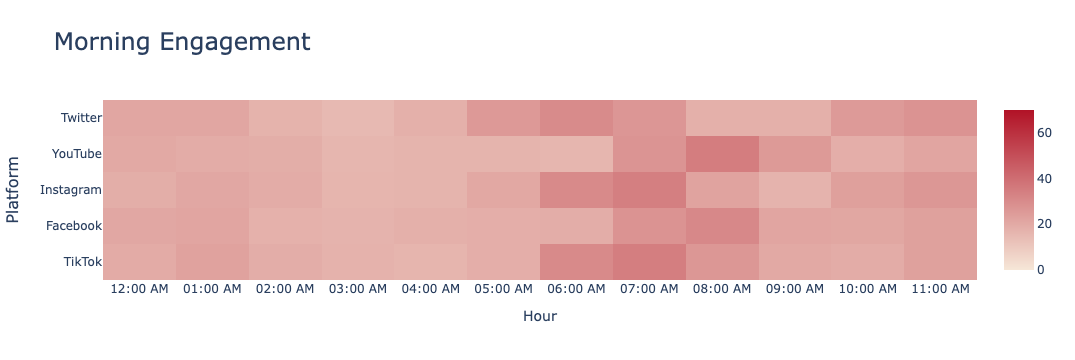

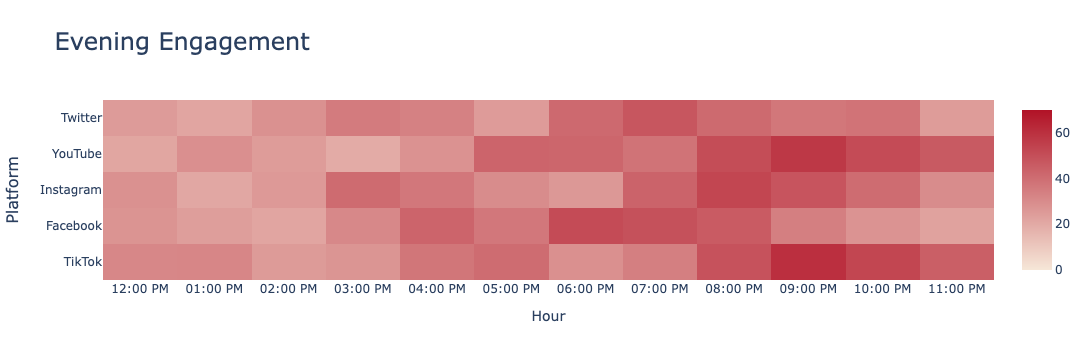

Saved to ../output/interactive_christmas_blog.html


In [447]:
# Section 3: Visualization & Dashboard (ML removed, using engagement_score directly)

import plotly.graph_objects as go
from IPython.display import display, HTML
from ipywidgets import Dropdown, VBox, Output

# Ensure output directory exists
os.makedirs('../output', exist_ok=True)

# Use engagement_score directly
df['predicted_score'] = df['engagement_score']

# Format hour labels consistently
df['hour_label'] = df['hour'].apply(lambda h: f"{(h%12 if h%12!=0 else 12):02d}:00 {'AM' if h<12 else 'PM'}")

# Define platforms and 24-hour labels
platforms_all = df['platform'].unique()
hours_24 = [f"{(h%12 if h%12!=0 else 12):02d}:00 {'AM' if h<12 else 'PM'}" for h in range(24)]

# Pivot heatmaps for morning and evening
pivot_morning = df[df['hour']<12].groupby(['platform','hour_label'])['predicted_score'].mean().unstack().reindex(index=platforms_all, columns=hours_24[:12], fill_value=0)
pivot_evening = df[df['hour']>=12].groupby(['platform','hour_label'])['predicted_score'].mean().unstack().reindex(index=platforms_all, columns=hours_24[12:], fill_value=0)

# Line chart: full engagement per platform
line_df = df.groupby(['platform','hour_label'])['predicted_score'].mean().unstack().reindex(index=platforms_all, columns=hours_24)
season_avg_line = line_df.mean(axis=0) 

# Build Top 3 posting hours table per platform per day
day_data = {}
for d, temp in df.groupby('date'):
    table = []
    for p in platforms_all:
        temp_p = temp[temp['platform'] == p]
        top3 = temp_p.nlargest(3, 'predicted_score')[['hour_label', 'predicted_score']]
        avg = temp_p['predicted_score'].mean()
        hour_scores = temp_p.set_index('hour_label')['predicted_score'].to_dict()
        for h in hours_24:
            if h not in hour_scores:
                hour_scores[h] = float(season_avg_line[h])
        table.append({
            'platform': p,
            'top3': top3.to_dict('records'),
            'average': avg,
            'hour_scores': hour_scores
        })
    day_data[d] = table

# Colors and heatmap range
heatmap_colors = ['#F6E7D8','#B11226']
platform_colors = {'Instagram':'#D62828','TikTok':'#F77F00','Facebook':'#F4A261','Twitter':'#2A9D8F','LinkedIn':'#264653'}
z_min, z_max = 0, 70

# Display notebook heatmaps
fig_morning = go.Figure(go.Heatmap(
    z=pivot_morning.values,
    x=pivot_morning.columns,
    y=pivot_morning.index,
    colorscale=heatmap_colors,
    zmin=z_min,
    zmax=z_max,
    hovertemplate='Platform: %{y}<br>Hour: %{x}<br>Engagement: %{z:.1f}<extra></extra>'
))
fig_morning.update_layout(title='Morning Engagement', title_font_size=24, xaxis_title='Hour', yaxis_title='Platform', yaxis_title_font_size=16, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
fig_morning.show()

fig_evening = go.Figure(go.Heatmap(
    z=pivot_evening.values,
    x=pivot_evening.columns,
    y=pivot_evening.index,
    colorscale=heatmap_colors,
    zmin=z_min,
    zmax=z_max,
    hovertemplate='Platform: %{y}<br>Hour: %{x}<br>Engagement: %{z:.1f}<extra></extra>'
))
fig_evening.update_layout(title='Evening Engagement', title_font_size=24, xaxis_title='Hour', yaxis_title='Platform', yaxis_title_font_size=16, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
fig_evening.show()

# Setup interactive widgets
dropdown = Dropdown(options=list(day_data.keys()), description='Select Date:', layout={'width':'250px'})
out_table = Output()
out_line = Output()

# Function to update Top3 table and line chart dynamically
def update_dashboard(change):
    date = change['new']
    table = day_data[date]

    # Update Top3 table
    with out_table:
        out_table.clear_output()
        html = '<table style="width:100%; border-collapse:collapse;"><tr><th>Platform</th><th>Top 3 Hours</th><th>Average</th></tr>'
        for row in table:
            top_str = ', '.join([f"{x['hour_label']} ({x['predicted_score']:.1f})" for x in row['top3']])
            html += f"<tr><td>{row['platform']}</td><td>{top_str}</td><td>{row['average']:.1f}</td></tr>"
        html += '</table>'
        display(HTML(html))

    # Update line chart
    with out_line:
        out_line.clear_output()
        fig_line = go.Figure()
        
        # Use hour_scores from table for selected date
        hour_scores_dict = {row['platform']: row['hour_scores'] for row in table}

        for platform in platforms_all:
            y_vals = [hour_scores_dict[platform][h] for h in hours_24]
            fig_line.add_trace(go.Scatter(
                x=hours_24,
                y=y_vals,
                mode='lines+markers',
                name=platform,
                line=dict(color=platform_colors.get(platform,'#111'), width=2)
            ))

        # Add season average line
        fig_line.add_trace(go.Scatter(
            x=hours_24,
            y=season_avg_line.values,
            mode='lines',
            name='Season Avg',
            line=dict(color='black', dash='dash', width=2)
        ))

        # Highlight peak hours
        peak_hours = sorted([x['hour_label'] for row in table for x in row['top3']], key=lambda h: hours_24.index(h))
        if peak_hours:
            fig_line.add_vrect(
                x0=peak_hours[0], x1=peak_hours[-1],
                fillcolor="#FFD166", opacity=0.3, line_width=0
            )

        fig_line.update_layout(
            title=f'Hourly Engagement Trends ({date})',
            xaxis_title='Hour',
            yaxis_title='Predicted Engagement',
            yaxis=dict(range=[z_min, z_max]),
            plot_bgcolor='rgba(0,0,0,0)',
            paper_bgcolor='rgba(0,0,0,0)',
            hovermode='x unified'
        )
        fig_line.show()

# Display widgets and initialize
display(VBox([dropdown, out_table, out_line]))
dropdown.observe(update_dashboard, names='value')
update_dashboard({'new': list(day_data.keys())[0]})

# The section below is OPTIONAL. if you want to viisualize the graphs, you can just stop here.

# Convert pivots and line data to JSON-friendly dicts
pivot_morning_json = pivot_morning.reset_index().to_dict(orient='records')
pivot_evening_json = pivot_evening.reset_index().to_dict(orient='records')
season_avg_json = season_avg_line.to_dict()

# Compute global min/max for heatmap colors (optional for visualization)
z_min = df['predicted_score'].min()
z_max = df['predicted_score'].max()

# Convert data for HTML
html_template = f"""
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8" />
<meta name="viewport" content="width=device-width, initial-scale=1" />
<title>Best Time to Post on Social Media This Christmas — Calista Jajalla</title>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Playfair+Display:wght@600;700&family=Inter:wght@400;500;600&display=swap" rel="stylesheet">
<script src="https://cdn.plot.ly/plotly-2.27.0.min.js"></script>

<style>
:root {{ --bg:#fff7f2; --ink:#243333; --muted:#5f6f73; --red:#B11226; --green:#1E6F5C; --gold:#C8A951; --cream:#F6E7D8; }}
body {{ margin:0; background:var(--bg); color:var(--ink); font-family:'Inter',system-ui,-apple-system,BlinkMacSystemFont,sans-serif; line-height:1.85; }}
.container {{ max-width:1400px; margin:auto; padding:32px 40px 32px; }}
header {{ text-align:center; margin-bottom:48px; }}
header h1 {{ font-family:'Playfair Display',serif; font-size:3rem; color:var(--red); margin-bottom:12px; }}
header h2 {{ font-family:'Playfair Display',serif; font-size:1.8rem; color:var(--green); margin-top:4px; }}
header p {{ color:var(--muted); font-size:1.2rem; max-width:1100px; margin:12px auto 0; text-align:left; }}
.hero {{ margin:36px 0 48px; border-radius:12px; overflow:hidden; box-shadow:0 12px 24px rgba(0,0,0,.08); height:400px; }}
.hero img {{ width:100%; height:100%; object-fit:cover; display:block; }}
h2 {{ font-family:'Playfair Display',serif; font-size:2.2rem; margin-top:20px; color:var(--green); text-align:left; }}
h3 {{ font-family:'Playfair Display',serif; font-size:1.7rem; margin-top:36px; color:var(--green); text-align:left; }}
.blog {{ max-width:1200px; margin:0px auto; font-size:1.15rem; line-height:1.8; text-align:left; }}
.insight-box {{ background:var(--cream); border-left:6px solid var(--gold); padding:22px 26px; margin:24px auto; border-radius:14px; max-width:1200px; font-size:1.15rem; }}
.controls {{ display:flex; gap:0px; justify-content:flex-start; margin:24px 0; flex-wrap:wrap; }}
select {{ padding:12px 16px; font-size:1.1rem; border-radius:10px; border:1px solid #ddd; cursor:pointer; }}
.chart {{ margin:10px auto; max-width:1200px; min-height:450px; }}
footer {{ text-align:center; margin-top:60px; color:var(--muted); font-size:1rem; }}
table {{ width:100%; border-collapse:collapse; margin:10px 0; font-size:1.05rem; }}
th, td {{ border:1px solid #ccc; padding:10px; text-align:center; }}
th {{ background-color:var(--red); color:white; }}
tr:nth-child(even) {{ background-color:#f4f4f4; }}
tr:hover {{ background-color:var(--cream); }}
@media (max-width:1024px) {{ .container {{ padding:24px 20px 48px; }} header h1 {{ font-size:2.4rem; }} header h2 {{ font-size:1.5rem; }} h2 {{ font-size:2rem; }} h3 {{ font-size:1.4rem; }} }}
@media (max-width:768px) {{ .container {{ padding:24px 16px 48px; }} header h1 {{ font-size:2rem; }} header h2 {{ font-size:1.25rem; }} h2 {{ font-size:1.6rem; }} h3 {{ font-size:1.3rem; }} }}
</style>
</head>
<body>

<div class="container">
<header>
<h1>Best Time to Post on Social Media This Christmas</h1>
<h2 style="text-align:center;">By Calista Jajalla</h2>
<p class="blog">
  <strong><em>Christmas in the Philippines is more than a holiday.</em></strong><br><br>
  It is a season filled with vibrant decorations, family gatherings, and moments people love to share online. During this period, Filipino users become more active on social media, creating valuable opportunities for brands, creators, and bloggers to reach a wider audience through well-timed posts.
</p>

<p class="blog"><br>
  <strong>Engagement</strong> here means how much people interact with posts—through likes, comments, shares, and views. This analysis looks at these interactions to highlight the best times to post across Instagram, TikTok, Facebook, YouTube, and X during the Christmas season.
</p>

<div class="hero">
<img src="https://www.rappler.com/tachyon/r3-assets/612F469A6EA84F6BAE882D2B94A4B421/img/F358AC5A1D5845EBBBD0BA0E97B008C2/sm-aura-christmas-03.jpg" alt="Philippine Christmas social media engagement">
</div>

<h2>Morning Engagement (12:00 AM - 11:00 AM)</h2>
<p class="blog">Mornings in the Philippines are often calm on social media, but this quiet can be an advantage. Early risers, students checking updates before class, and night owls catching up after late-night scrolling make up an attentive audience. <strong>Short updates</strong>, gentle reminders, and festive countdown posts work best during these hours because there is less competition for attention. Posting in the morning allows your content to gain traction before the platform traffic surges later in the day, giving your posts a better chance to stand out.</p>
<div class="insight-box"><strong>Strategy:</strong> Schedule lightweight posts, reminders, or small festive announcements during calm morning hours. Observe platform-specific micro-peaks to capture early engagement and build momentum for later in the day.</div>
<div id="morning_heatmap" class="chart"></div>

<h2>Evening Engagement (12:00 PM – 11:00 PM)</h2>
<p class="blog">Evenings are the heartbeat of social media activity in the Philippines. After work, school, or family gatherings, people scroll for entertainment, inspiration, and festive promotions. Videos, vibrant visuals, and interactive content perform best because the audience is both abundant and actively engaged. Staggering posts across platforms ensures your content reaches different audience segments effectively without competing with itself.</p>
<div class="insight-box"><strong>Strategy:</strong> Post your main videos, interactive stories, and festive promotions during evening hours. Focus on rich, attention-grabbing content to maximize engagement, shares, and overall visibility when your audience is most active.</div>
<div id="evening_heatmap" class="chart"></div>

<h2>Daily Posting Recommendations & Top 3 Hours</h2>
<p class="blog">Timing can make all the difference in reaching your audience. Select a date to view the top three hours per platform. Stagger posts to avoid overlap and maintain consistent engagement. Each platform has micro-peaks that can be exploited to optimize content performance. Understanding these patterns helps you plan content that resonates with Filipino audiences and maximizes reach during the Christmas season.</p>
<div class="controls">
<label><strong>Select date:</strong></label>
<select id="daySelector"></select>
</div>
<div id="top_div" class="chart"></div>

<h3>Hourly Engagement Peaks & Attention Windows</h3>
<p class="blog">Not all hours are equal, and some consistently outperform seasonal averages. These *golden windows* are ideal times to post videos, stories, or promos. Highlighted bands on the charts show the best posting windows for each platform. Interacting with the chart allows you to refine schedules and make data-driven decisions for maximum visibility throughout the season.</p>
<div class="insight-box"><strong>Strategy:</strong> Focus your best content during these highlighted windows. Adjust content type and timing according to platform and audience behavior. Monitoring daily shifts in engagement ensures that your posts consistently capture attention during the festive period.</div>
<div id="line_div" class="chart"></div>

<h2>End Remarks</h2>
<p class="blog"><strong>Wrapping it up:</strong> Mornings provide quiet opportunities to engage an attentive audience, while evenings deliver high-volume interactions that can help your content go further. Using these charts, top-hour tables, and micro-peaks allows you to schedule posts strategically and ensure your content reaches the right people. With careful timing and consistent observation of engagement patterns, your posts can shine brighter than Christmas lights across the Philippines this festive season.</p>
</div>

<footer>
<p>Based on synthetic Philippine Christmas 2025 engagement data. Analysis and visualization by Calista Jajalla.</p>
</footer>
</div>

<script>
const pivotMorning = {json.dumps(pivot_morning_json)};
const pivotEvening = {json.dumps(pivot_evening_json)};
const seasonAvg = {json.dumps(season_avg_json)};
const dayData = {json.dumps(day_data)};
const platformColors = {json.dumps(platform_colors)};
const hours24 = Object.keys(seasonAvg);
const zMin = {z_min};
const zMax = {z_max};

function heatmap(id, data, title) {{
    if (!data || !data.length) return;

    const x = Object.keys(data[0]).filter(k => k !== 'platform');
    const y = data.map(d => d.platform);
    const z = data.map(d => x.map(k => Number(d[k])));

    Plotly.newPlot(
        id,
        [
            {{
                z: z,
                x: x,
                y: y,
                type: 'heatmap',
                colorscale: [
                    [0, '#F6E7D8'],
                    [1, '#B11226']
                ],
                zmin: 0,
                zmax: 65,
                hovertemplate:
                    '%{{x}}<br>' +
                    'Platform: %{{y}}<br>' +
                    'Engagement: %{{z:.1f}}' +
                    '<extra></extra>'
            }}
        ],
        {{
            title: title,
            xaxis: {{ title: 'Hour' }},
            yaxis: {{
                title: 'Platform',
                title_standoff: 40   
            }},
            margin: {{ l: 120 }},    
            paper_bgcolor: '#fff7f2',
            plot_bgcolor: '#fff7f2',
            responsive: true
        }}
    );
}}


function render(date) {{
    const rows = dayData[date];
    let html = '<table><tr><th>Platform</th><th>Top 3 Hours</th><th>Avg</th></tr>';

    rows.forEach(r => {{
        const top = r.top3
            .map(x => `${{x.hour_label}} (${{Number(x.predicted_score).toFixed(1)}})`)
            .join(', ');
        html += `<tr><td>${{r.platform}}</td><td>${{top}}</td><td>${{Number(r.average).toFixed(1)}}</td></tr>`;
    }});

    html += '</table>';
    document.getElementById('top_div').innerHTML = html;

    // Compute dynamic peak window
    let allTopHours = [];
    rows.forEach(r => allTopHours.push(...r.top3.map(x => x.hour_label)));
    allTopHours = allTopHours.sort((a,b) => hours24.indexOf(a) - hours24.indexOf(b));
    const peakStart = allTopHours[0];
    const peakEnd = allTopHours[allTopHours.length-1];

    const shapes = [
        {{
            type: 'rect',
            xref: 'x',
            yref: 'paper',
            x0: peakStart,
            x1: peakEnd,
            y0: 0,
            y1: 1,
            fillcolor: '#FFD166',
            opacity: 0.3,
            line: {{ width: 0 }}
        }}
    ];

    const traces = rows.map(r => {{
        return {{
            x: hours24,
            y: hours24.map(h => {{
                const found = r.top3.find(x => x.hour_label === h);
                return found ? Number(found.predicted_score) : Number(seasonAvg[h]);
            }}),
            mode: 'lines+markers',
            name: r.platform,
            line: {{ color: platformColors[r.platform] || '#111', width: 2 }}
        }};
    }});

    traces.push({{
        x: hours24,
        y: Object.values(seasonAvg).map(Number),
        mode: 'lines',
        name: 'Season Avg',
        line: {{ dash: 'dash', color: '#111', width: 2 }}
    }});

    Plotly.newPlot('line_div', traces, {{
        title: `Hourly Engagement Trends`,
        xaxis: {{ title: 'Hour' }},
        yaxis: {{ title: 'Predicted Engagement', range: [0, zMax] }},
        shapes: shapes,
        paper_bgcolor: '#fff7f2',
        plot_bgcolor: '#fff7f2',
        hovermode: 'x unified',
        responsive: true
    }});
}}


heatmap('morning_heatmap', pivotMorning, 'Morning Engagement');
heatmap('evening_heatmap', pivotEvening, 'Evening Engagement');

const sel = document.getElementById('daySelector');
Object.keys(dayData).forEach(d => {{
    const o = document.createElement('option');
    o.value = d;
    o.text = d;
    sel.appendChild(o);
}});

render(sel.value = Object.keys(dayData)[0]);
sel.onchange = e => render(e.target.value);
</script>
</body>
</html>
"""

with open("../output/interactive_christmas_blog.html", "w", encoding="utf-8") as f:
    f.write(html_template)

print("Saved to ../output/interactive_christmas_blog.html")

### These predicted engagement peaks align with typical Filipino social media usage patterns during lunch breaks, evening leisure hours, and weekends